This notebook aims to predict Gold Glove winners. It uses Sean Lahman's baseball stats database as its primary source

The database used in the model is copyright 1996-2017 by Sean Lahman. It is licensed under a Creative Commons Attribution-ShareAlike 3.0 Unported License.  For details see: http://creativecommons.org/licenses/by-sa/3.0/

Import relevant libraries

In [1]:
%matplotlib inline
%pylab inline

import pandas as pd
from pandas import DataFrame

import numpy as np

import boto3
import io

import xgboost as xgb
from xgboost import plot_tree

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


C:\Users\Simon Wintels\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Main definitions

In [2]:
#Set LOCAL to False if you want to read from AWS S3
LOCAL = True
LOCAL_FILE_DIR = "./input/sldb2017/"
BUCKET ="wintels.coursera.baseball"

YEARS = range(1957,2016)
POSITION_GROUPS = ["INF"] #["P", "C", "INF", "OUTF" ]
POS_IN_GROUPS ={"INF":["1B","2B","3B","SS"], "OUTF": ["OF"], "P":["P"],"C":["C"]}

#YEAR = 2015 #should be removed
#POSITION = "1B" #should be removed

Read 2016 baseball database stored at AWS S3 (or locally)

In [3]:
def read_df_from_S3(csv_file):
    s3 = boto3.client('s3'
    #local only
                        , aws_access_key_id="",
                          aws_secret_access_key=""
    #
                     )
    obj = s3.get_object(Bucket=BUCKET, Key='2017/'+csv_file) 
    temp_df = pd.read_csv(io.BytesIO(obj["Body"].read()))
    return temp_df

In [4]:
df_master = read_df_from_S3('Master.csv') if not(LOCAL) else pd.read_csv(LOCAL_FILE_DIR+'Master.csv')
df_fielding = read_df_from_S3('Fielding.csv') if not(LOCAL) else pd.read_csv(LOCAL_FILE_DIR+'Fielding.csv')
df_appearances = read_df_from_S3('Appearances.csv') if not(LOCAL) else pd.read_csv(LOCAL_FILE_DIR+'Appearances.csv')
df_batting = read_df_from_S3('Batting.csv') if not(LOCAL) else pd.read_csv(LOCAL_FILE_DIR+'Batting.csv')
df_fielding = read_df_from_S3('Fielding.csv') if not(LOCAL) else pd.read_csv(LOCAL_FILE_DIR+'Fielding.csv')
df_teams = read_df_from_S3('Teams.csv') if not(LOCAL) else pd.read_csv(LOCAL_FILE_DIR+'Teams.csv')

df_gg = read_df_from_S3('ggwinners.csv') if not(LOCAL) else pd.read_csv('./input/ggwinners.csv')

Define function to one_hot encode non-numerical features (e.g. "bats", "throws") to ensure XGBoost can work with them. It creates a column for every possible value in the original column

In [5]:
def one_hot_encode(column, df, remove=False):

    label_encoder = LabelEncoder()
    df_recoded = label_encoder.fit_transform(df[column].fillna("NA"))
    df_recoded = df_recoded.reshape(df.shape[0],1)
    onehot_encoder = OneHotEncoder(sparse=False)
    df_recoded = onehot_encoder.fit_transform(df_recoded)

    col =[] 
    for i in range(0,df_recoded.shape[1]):
        col.append(column + "_"+ label_encoder.classes_[i])
    
    df_recoded = DataFrame(df_recoded, columns=col)
    if(remove):
        df.pop(column)
    return df_recoded

Return a dataframe with all the relevant features by player, given a position and a year

In [6]:
def populate_features(position_group, year):
    
    #Select only active players in the Position group
    active_players = df_appearances[df_appearances.yearID==year]["playerID"]
    df_master_year = df_master[df_master.playerID.isin(active_players)].reset_index(drop=True)
       
    #Filter out only position in the position group
    df_field_group = df_fielding[df_fielding.yearID==year].sort_values(by=['playerID','G'], ascending=[True,False]).drop_duplicates("playerID")
    df_field_group = df_field_group[df_field_group.POS.isin(POS_IN_GROUPS[position_group])]
    
    #Fielding
    df_field_group["fielding_average"] = (df_field_group.PO+df_field_group.A)/(df_field_group.PO+df_field_group.A+df_field_group.E)
    df_field_group["double_play_rate"] = (df_field_group.DP)/(df_field_group.PO+df_field_group.A+df_field_group.E)
    df_field_group["putout_vs_assist"] = (df_field_group.PO)/df_field_group.A
    df_field_group["activity"] = (df_field_group.PO+df_field_group.A)/(df_field_group.InnOuts)
        
    df_master_year = pd.merge(df_master_year, df_field_group,how='inner', on=['playerID','playerID'])    
    del df_master_year['yearID']
    del df_master_year['lgID']
    del df_master_year['stint']
        
    #Appearances
    df_app_group=df_appearances[df_appearances.yearID==year].groupby(df_appearances['playerID']).sum().reset_index()
    df_master_year = pd.merge(df_master_year, df_app_group,how='left', on=['playerID','playerID'])
    del df_master_year['yearID']
    
    #Batting
    df_bat_group=df_batting[df_batting.yearID==year].groupby(df_batting['playerID']).sum().reset_index()
    df_bat_group["batting_average"] = df_bat_group.H / df_bat_group.AB
    df_bat_group["on_base_percentage"] = (df_bat_group.H + df_bat_group.BB +df_bat_group.HBP) / (df_bat_group.AB+ df_bat_group.BB+ df_bat_group.HBP+df_bat_group.SF)
    df_bat_group["1B"] = df_bat_group.H - df_bat_group["2B"]- df_bat_group["3B"] - df_bat_group.HR
    df_bat_group["slugging_percentage"] = (df_bat_group["1B"] + 2*df_bat_group["2B"] +3*df_bat_group["3B"]+4*df_bat_group["HR"]) / df_bat_group.AB
    df_bat_group["RBI_rate"] = df_bat_group.RBI / df_bat_group.AB
    df_master_year = pd.merge(df_master_year, df_bat_group,how='left', on=['playerID','playerID'])
    del df_master_year['yearID']
    
    #Team performance
    df_team_group = df_teams[df_teams.yearID==year][["teamID", "Rank", "W", "DivWin", "WCWin","LgWin","WSWin","FP","E"]]
    df_team_group["E_team"]=df_team_group.pop("E")
                                                    
    df_team_group = df_team_group = df_team_group.replace(['Y', 'N'], [1, 0])
    df_master_year = pd.merge(df_master_year, df_team_group,how='left', on=['teamID','teamID'])
        
    #One hot encode several features
    df_master_year = pd.concat([df_master_year, one_hot_encode("bats", df_master_year, True)], axis=1)
    df_master_year = pd.concat([df_master_year, one_hot_encode("throws", df_master_year, True)], axis=1)
    df_master_year = pd.concat([df_master_year, one_hot_encode("POS", df_master_year, True)], axis=1)
     
    #Other features
    df_master_year["age_in_season"] = year - df_master_year["birthYear"]
        
    #Target label creation
    winners = df_gg[(df_gg.Year==year)& (df_gg.Position_group == position_group)]['playerID']
    df_master_year["won"]=df_master_year.playerID.isin(winners)*1
    df_master_year["stat_year"] = year
        
    return df_master_year

Remove features that won't be used for XGBoost model

In [7]:
def clean_features(df, feature_names=None):
    if(feature_names is None):
        not_features = ['playerID','birthYear','birthMonth','birthDay','birthCountry', 'birthState','birthCity','deathYear','deathMonth','deathDay',
                        'debut','finalGame','deathCountry','deathState','deathCity','nameFirst','nameLast',
                        'nameGiven','retroID','bbrefID','throws_S', 'stint', 'teamID', 
                        'franchID', 'divID', 'name', 'park',
                        'lgID', 'teamIDBR','teamIDlahman45','teamIDretro']
        feature_names = [f for f in df.columns if f not in not_features]
    return df[feature_names], feature_names

Create master dataframe that contains all training data

In [8]:
df_train = pd.DataFrame()
for position_group in POSITION_GROUPS:
    frames = [populate_features(position_group, year) for year in YEARS]
    frame_order = frames[0].keys().values # can be removed later
    df_train = pd.concat(frames)
    df_train = df_train[np.concatenate((frame_order,[c for c in df_train.columns if c not in frame_order]))]
    df_features, feature_names = clean_features(df_train)

In [9]:
print(df_train.keys())
print(df_train.shape)

Index(['playerID', 'birthYear', 'birthMonth', 'birthDay', 'birthCountry',
       'birthState', 'birthCity', 'deathYear', 'deathMonth', 'deathDay',
       'deathCountry', 'deathState', 'deathCity', 'nameFirst', 'nameLast',
       'nameGiven', 'weight', 'height', 'debut', 'finalGame', 'retroID',
       'bbrefID', 'teamID', 'G_x', 'GS_x', 'InnOuts', 'PO', 'A', 'E', 'DP',
       'PB', 'WP', 'SB_x', 'CS_x', 'ZR', 'fielding_average',
       'double_play_rate', 'putout_vs_assist', 'activity', 'G_all', 'GS_y',
       'G_batting', 'G_defense', 'G_p', 'G_c', 'G_1b', 'G_2b', 'G_3b', 'G_ss',
       'G_lf', 'G_cf', 'G_rf', 'G_of', 'G_dh', 'G_ph', 'G_pr', 'stint', 'G_y',
       'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB_y', 'CS_y', 'BB', 'SO',
       'IBB', 'HBP', 'SH', 'SF', 'GIDP', 'batting_average',
       'on_base_percentage', '1B', 'slugging_percentage', 'RBI_rate', 'Rank',
       'W', 'DivWin', 'WCWin', 'LgWin', 'WSWin', 'FP', 'E_team', 'bats_B',
       'bats_L', 'bats_R', 'throws_L', 'throw

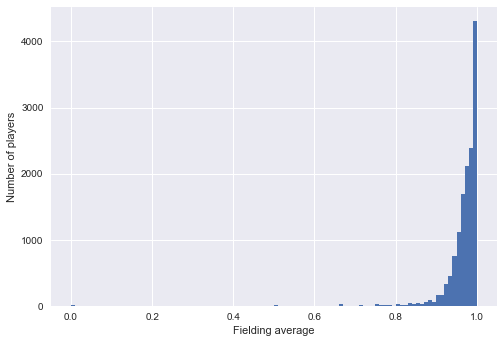

In [10]:
plt.hist(df_train["fielding_average"].dropna(), bins=100)
plt.xlabel('Fielding average')
plt.ylabel('Number of players')
plt.show()

Split dataset into two

In [11]:
Xtr = df_features[df_features.stat_year%4!=0]
Xv  = df_features[df_features.stat_year%4==0]
ytr = Xtr.pop("won")
yv  = Xv.pop("won")

df_test_full = populate_features("INF", 2016)
df_test, te_feature_names = clean_features(df_test_full, feature_names)
yreal = df_test.pop("won")
print(Xtr.shape)
print(df_test.shape)

(10721, 76)
(285, 76)


In [12]:
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)
dtest = xgb.DMatrix(df_test)

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

xgb_pars = {'min_child_weight': 1, 'eta': 0.005, 'colsample_bytree': 0.8, 'max_depth': 8,
            'subsample': 0.5, 'lambda': 1.5, 'booster' : 'gbtree', 'silent': 0,
            'eval_metric': ['auc','logloss'], 'objective': 'binary:logistic'}

model = xgb.train(xgb_pars, dtrain, 2500, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=100)

print('Modeling score %.5f' % model.best_score)
#t1 = dt.datetime.now()
#print('Training time: %i seconds' % (t1 - t0).seconds)


[0]	train-auc:0.838914	train-logloss:0.688681	valid-auc:0.832749	valid-logloss:0.688757
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[100]	train-auc:0.969063	train-logloss:0.390049	valid-auc:0.92216	valid-logloss:0.395703
[200]	train-auc:0.979238	train-logloss:0.244994	valid-auc:0.927222	valid-logloss:0.256238
[300]	train-auc:0.985316	train-logloss:0.165208	valid-auc:0.932741	valid-logloss:0.181942
[400]	train-auc:0.989011	train-logloss:0.118155	valid-auc:0.937776	valid-logloss:0.140144
[500]	train-auc:0.991609	train-logloss:0.089206	valid-auc:0.940467	valid-logloss:0.115891
[600]	train-auc:0.994153	train-logloss:0.070758	valid-auc:0.942121	valid-logloss:0.101597
[700]	train-auc:0.995664	train-logloss:0.058342	valid-auc:0.945069	valid-logloss:0.093074
[800]	train-auc:0.996694	train-logloss:0.049743	valid-auc:0.948925	valid-logloss:0.088089
[900]	train-auc:0.997378	train-logloss:0.0

In [13]:
feature_importance_dict = model.get_fscore()
fs = ['f%i' % i for i in range(len(feature_names))]
f1 = pd.DataFrame({'f': list(feature_importance_dict.keys()), 'importance': list(feature_importance_dict.values())})
feature_importance = f1
#feature_importance = feature_importance.fillna(0)
feature_importance[['f', 'importance']].sort_values(by='importance', ascending=False).head(10)

,f,importance
9,fielding_average,2376
28,A,1999
6,SO,1884
10,E_team,1825
23,InnOuts,1821
19,W,1699
18,putout_vs_assist,1699
46,stat_year,1669
16,SB_y,1604
8,double_play_rate,1551


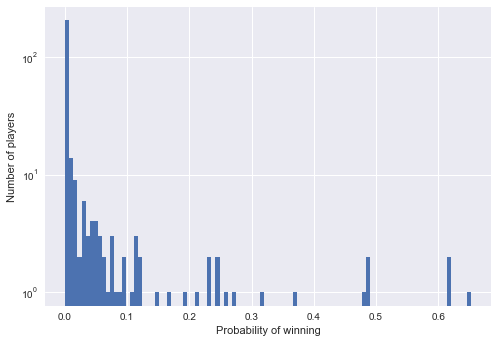

In [14]:
ypred = pd.DataFrame(model.predict(dtest),columns=["win_chance"])
yreal = pd.DataFrame(yreal,columns=["won"])
plt.hist(ypred.values, bins=100)
plt.yscale('log', nonposy='clip')
plt.xlabel('Probability of winning')
plt.ylabel('Number of players')
plt.show()

In [15]:
df_t = pd.concat([df_test_full,ypred], axis=1)
df_t.to_csv('predictions.csv')

http://m.mlb.com/news/article/207322712/gold-glove-award-finalists/

In [16]:
nominated={2016:
           ["dickera01","keuchda01", "verlaju01",
            "mccanja02","perezca02","perezsa02", 
            "davisch02","hosmeer01","morelmi01",
            "canoro01","kinslia01", "pedrodu01",
            "beltrad01","machama01","seageky01",
            "iglesjo01","lindofr01","simmoan01",
            "gardnbr01","gordoal01","rasmuco01",
            "bradlja02","pillake01","kiermke01",
            "bettsmo01","eatonad02","springe01",
            "arrieja01","greinza01","wainwad01",
            "lucrojo01","molinya01","poseybu01",
            "goldspa01","myerswi01","rizzoan01",
            "lemahdj01","panikjo01","segurje01",
            "arenano01","rendoan01","turneju01",
            "crawfbr01","galvifr01","russead02",
            "duvalad01","martest01","yelicch01",
            "hamilbi02","herreod01","inciaen01",
            "gonzaca01","heywaja01","markani01"
            ]}

df_t["nominated"] = df_t.playerID.isin(nominated[2016])

t

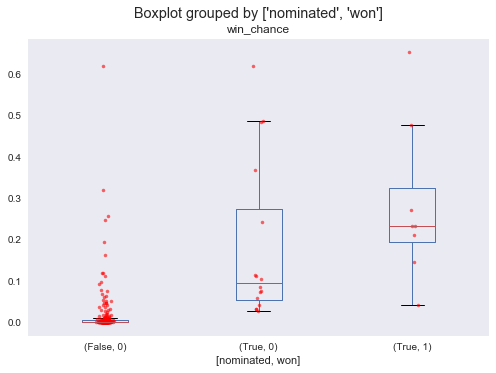

In [17]:
df_t.boxplot(column='win_chance', by=['nominated','won'], grid=False)
for i in [0,1]:
    for j in [0,1]:
        y = df_t.win_chance[(df_t.nominated==i)&(df_t.won==j)].dropna()
        # Add some random "jitter" to the x-axis
        x = np.random.normal(i+j+1, 0.02, size=len(y))
        plot(x, y, 'r.', alpha=0.6)

Winning chances (according to the model) of the actual winners

In [18]:
disp = ["playerID","nameFirst","nameLast","win_chance","won","nominated"]
df_t[(df_t.won==1)].sort_values(by="win_chance", ascending=False)[disp]

,playerID,nameFirst,nameLast,win_chance,won,nominated
16,arenano01,Nolan,Arenado,0.652831,1,True
215,rizzoan01,Anthony,Rizzo,0.477846,1,True
56,crawfbr01,Brandon,Crawford,0.272504,1,True
145,lindofr01,Francisco,Lindor,0.232416,1,True
26,beltrad01,Adrian,Beltre,0.232273,1,True
135,kinslia01,Ian,Kinsler,0.211539,1,True
181,panikjo01,Joe,Panik,0.147184,1,True
166,morelmi01,Mitch,Moreland,0.042088,1,True


Winning chances (according to the model) of those nominated, but not having won

In [19]:
df_t[(df_t.won==0)&(df_t.nominated)].sort_values(by="win_chance", ascending=False)[disp]

,playerID,nameFirst,nameLast,win_chance,won,nominated
186,pedrodu01,Dustin,Pedroia,0.618916,0,True
100,goldspa01,Paul,Goldschmidt,0.487368,0,True
42,canoro01,Robinson,Cano,0.484005,0,True
143,lemahdj01,DJ,LeMahieu,0.367970,0,True
241,seageky01,Kyle,Seager,0.242387,0,True
209,rendoan01,Anthony,Rendon,0.115407,0,True
150,machama01,Manny,Machado,0.111777,0,True
172,myerswi01,Wil,Myers,0.105766,0,True
120,hosmeer01,Eric,Hosmer,0.086189,0,True
93,galvifr01,Freddy,Galvis,0.076037,0,True


Players that should have been nominated given their performance

In [20]:
df_nominandum = df_t[(df_t.nominated==False) & (df_t.win_chance>df_t[df_t.nominated==True]["win_chance"].mean())]
df_nominandum.sort_values(by="win_chance", ascending=False)[disp]

,playerID,nameFirst,nameLast,win_chance,won,nominated
9,altuvjo01,Jose,Altuve,0.618768,0,False
89,freemfr01,Freddie,Freeman,0.319979,0,False
101,gonzaad01,Adrian,Gonzalez,0.257124,0,False
53,correca01,Carlos,Correa,0.247477,0,False


Have these guys won before?

In [21]:
df_earlier_wins= pd.merge(df_nominandum[['playerID']], df_train, on=['playerID','playerID'], how='inner')[["playerID",'nameFirst','nameLast',"won","stat_year"]]
df_earlier_wins= df_earlier_wins.groupby(['playerID','nameFirst','nameLast']).sum()
del df_earlier_wins["stat_year"]
df_earlier_wins["has_won_GG_earlier"] = (df_earlier_wins["won"]>0)

df_earlier_wins["number_of_wins"] = df_earlier_wins.pop("won")
df_earlier_wins.sort_values(by='number_of_wins',ascending=False)

,,,has_won_GG_earlier,number_of_wins
playerID,nameFirst,nameLast,,
gonzaad01,Adrian,Gonzalez,True,4
altuvjo01,Jose,Altuve,True,1
correca01,Carlos,Correa,False,0
freemfr01,Freddie,Freeman,False,0


ExecutableNotFound: failed to execute ['dot', '-Tpng'], make sure the Graphviz executables are on your systems' PATH

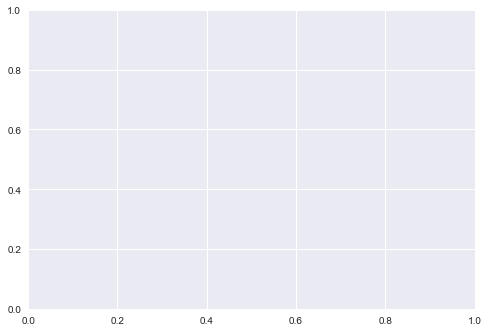

In [23]:
plot_tree(model)